In [3]:

import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import glob
import config
import pandas as pd 

if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    lithdir = datadir.joinpath('lith/sgems/')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')

flopy is installed in /home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/flopy
system: linux


In [4]:
#%% Useful functions
def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))


### Load salinity data and success/failure of runs

##### Load the data

Case: SV
Number of SEAWAT runs: 499 
Failure rate: 4.01 %
loading...
kper 40 it 0
kper 40 it 100
kper 40 it 200
kper 40 it 300
kper 40 it 400
matrices line up!
  
3. Dimension reduction of model and data
2020-07-11 10:08:37:157349
2020-07-11 10:08:55:678867
QC of the model eigen images
2020-07-11 10:08:58:828020
2020-07-11 10:08:59:262320
  
5. Global Sensitivity anlaysis-DGSA


100%|██████████| 3000/3000 [00:55<00:00, 54.47it/s]


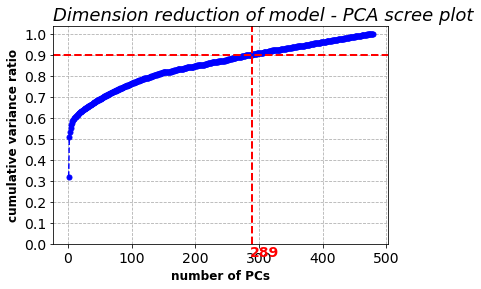

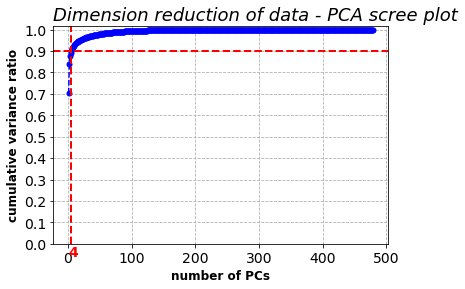

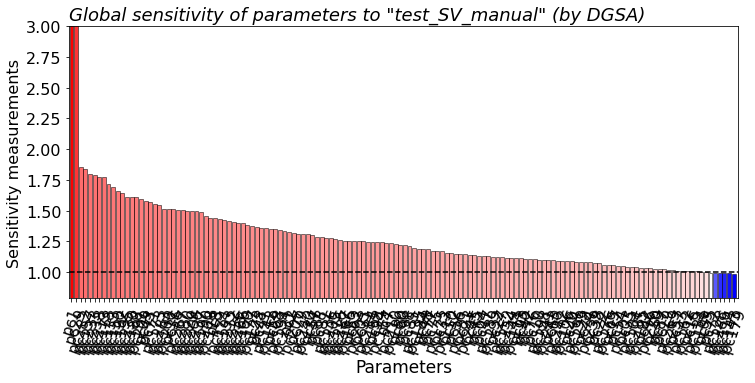

Case: SV
Number of SEAWAT runs: 499 
Failure rate: 4.01 %
loading...
kper 60 it 0
kper 60 it 100
kper 60 it 200
kper 60 it 300
kper 60 it 400
matrices line up!
  
3. Dimension reduction of model and data
2020-07-11 10:15:13:564647
2020-07-11 10:15:31:832156
QC of the model eigen images
2020-07-11 10:15:34:941931
2020-07-11 10:15:35:209085
  
5. Global Sensitivity anlaysis-DGSA


100%|██████████| 3000/3000 [00:56<00:00, 53.18it/s]


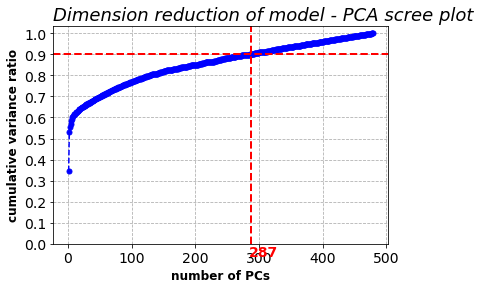

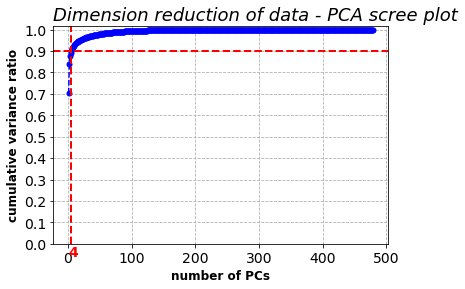

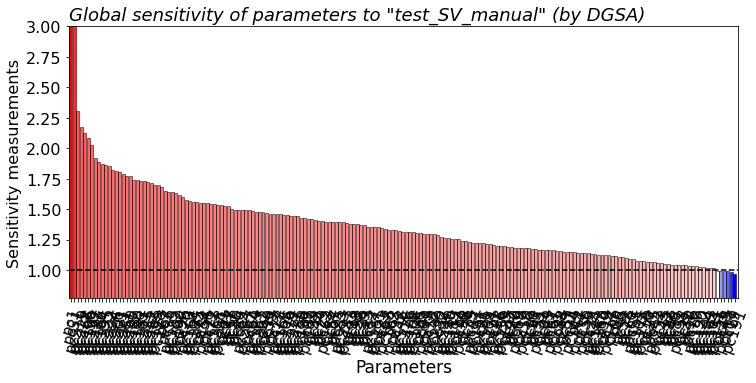

Case: SV
Number of SEAWAT runs: 499 
Failure rate: 4.01 %
loading...
kper 70 it 0
kper 70 it 100
kper 70 it 200
kper 70 it 300
kper 70 it 400
matrices line up!
  
3. Dimension reduction of model and data
2020-07-11 10:21:27:991886
2020-07-11 10:21:46:187192
QC of the model eigen images
2020-07-11 10:21:50:863551
2020-07-11 10:21:51:380553
  
5. Global Sensitivity anlaysis-DGSA


100%|██████████| 3000/3000 [00:54<00:00, 55.42it/s]


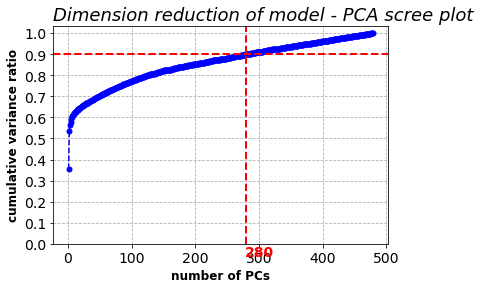

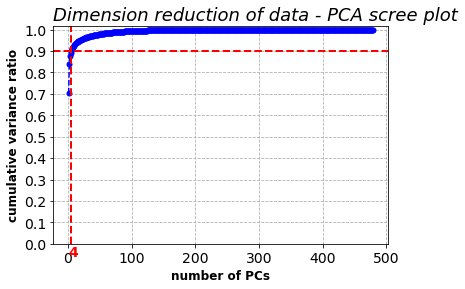

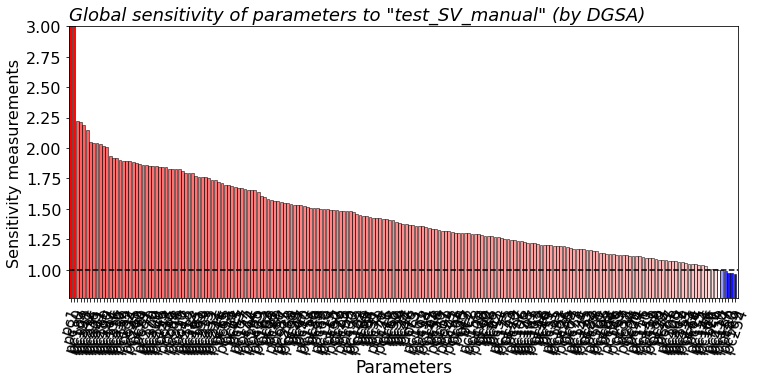

Case: SV
Number of SEAWAT runs: 499 
Failure rate: 4.01 %
loading...
kper 80 it 0
kper 80 it 100
kper 80 it 200
kper 80 it 300
kper 80 it 400
matrices line up!
  
3. Dimension reduction of model and data
2020-07-11 10:27:38:681628
2020-07-11 10:27:56:892510
QC of the model eigen images
2020-07-11 10:27:59:836173
2020-07-11 10:28:00:274082
  
5. Global Sensitivity anlaysis-DGSA


100%|██████████| 3000/3000 [00:52<00:00, 57.29it/s]


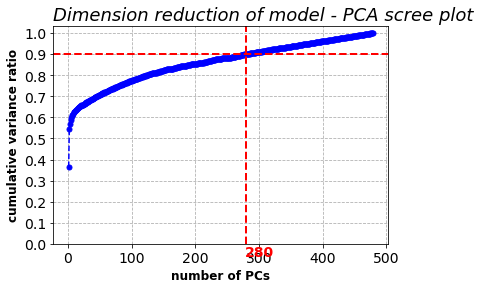

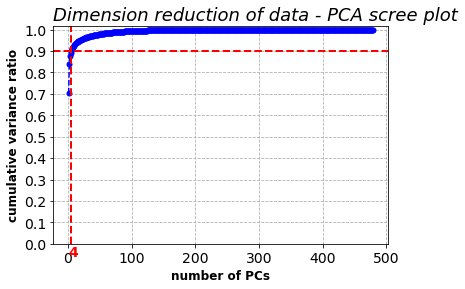

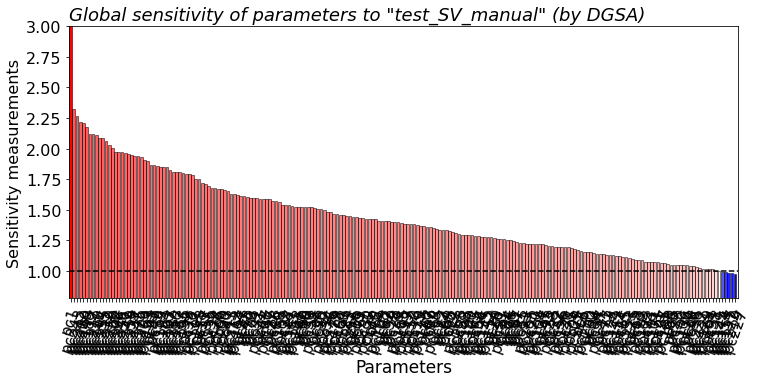

In [5]:
        
#Load a specific concentration for prediction variable
#Already ran kper=0,10,20,30
for kper in (40,60,70,80):


    job_id_AEM = 3573022
    job_id_conc = 3573022
    case='SV'


    # job_id_AEM = 3573239
    # job_id_conc = 3573239 

    # job_id_conc = 3753616 #Jul 7, 2020
    # job_id_conc = 3845000 #Jul 9, 2020
    # case='NM'



    ## Find AEM data files
    ouput_AEM = Path('/scratch/users/ianpg/SWIlarge/work/output/AEM/data/')
    aempaths = glob.glob(ouput_AEM.joinpath('{case}*_{job_id}.npy'.format(case=case,job_id=job_id_AEM)).as_posix())
    its_AEM = np.array([int(f.split('_')[-2]) for f in aempaths])


    output_case = Path('/scratch/users/ianpg/SWIlarge/work/output/{}'.format(case))
    f_varlist = Path('../data/PriorModel/varlist.pkl')
    varlist = load_obj(f_varlist.parent,'varlist')
    ucnpaths = glob.glob(output_case.joinpath('*_{job_id}.UCN'.format(job_id=job_id_conc)).as_posix())
    totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
    its_tds = np.array([int(f.split('_')[0].split('/')[-1].lstrip('conc')) for f in ucnpaths])
    failed = totims<14782
    its_failed = its_tds[failed]
    its_success = its_tds[~failed]
    success_AEM = np.array([True if it in its_AEM else False for it in its_tds])

    strange = [(it in its_failed) for it in its_AEM]
    if np.any(strange):
        print('something weird here... failed seawat run ended up with AEM data?')
    #     print('removing these indices...')
    #     success_AEM[np.array(strange)] = False

    print('Case: {}\nNumber of SEAWAT runs: {} \nFailure rate: {} %'.format(case,len(failed),np.round(100*sum(failed)/len(failed),2)))

    print('loading...')
    '''
    d_conc and d_AEM stored by iteration number so there are some empty indices along first axis corresponding to its_failed
    '''
    # d_conc = np.zeros((500,20, 19, 345),dtype=np.float)
    # d_conc_flat = np.zeros((500,20, 19, 345),dtype=np.float)


    # d_AEM = np.zeros((500,2940),dtype=np.float) 
    flag=0
    for f,it_AEM in zip(aempaths,its_AEM):
        if flag==0:
            matshape_AEM = np.load(f).shape
            matsize_AEM= np.prod(matshape_AEM)
            d_AEM = np.zeros((max(its_tds+1),matsize_AEM),dtype=np.float) 
            flag=1
        d_AEM[it_AEM] = np.load(f,allow_pickle=True)


    # flag=0
    # for f,it_tds,it_inAEM in zip(ucnpaths,its_tds,success_AEM):   
    #     if it_inAEM:
    #         if flag==0:
    #             matshape_conc = np.load(f.rstrip('UCN') + 'npy').shape
    #             matsize_conc = np.prod(matshape_conc)
    #             d_conc = np.zeros((max(its_tds+1),matsize_conc))
    #             flag=1
    #         d_conc[it_tds] = np.load(f.rstrip('UCN') + 'npy').flatten()


    
    
    
    
    
    flag=0
    # kper=30   #survey kper: 53
    for i,(f,it_tds,it_inAEM) in enumerate(zip(ucnpaths,its_tds,success_AEM)):  
        if i%100==0:
            print('kper',kper,'it',i)
        if it_inAEM:
            if flag==0:
                matshape_conc = np.load(f.rstrip('UCN') + 'npy').shape
                matsize_conc = np.prod(matshape_conc)
                d_conc = np.zeros((max(its_tds+1),matsize_conc))
                flag=1
    #         d_conc[it_tds] = np.load(f.rstrip('UCN') + 'npy').flatten()
            ucnobj = flopy.utils.binaryfile.UcnFile(f)
            d_conc[it_tds] = ucnobj.get_data(kstpkper=(0,kper)).flatten()







    #Verify that mats have missing rows in same indices
    if np.all((np.where(~d_conc.any(axis=1))[0] ==  np.where(~d_AEM.any(axis=1))[0])):
        print('matrices line up!')
    else:
        print('Warning: matrices do not line up!')        


    keep_inds = np.where(d_conc.any(axis=1))[0]
    d_AEM = -d_AEM[keep_inds,:]
    d_conc = d_conc[keep_inds,:]

    its_AEM = np.sort(its_AEM)
    its_tds = np.sort(its_tds[success_AEM])




    #FROM AUTOBEL

    autobeldir = 'source_code/'
    if autobeldir not in sys.path:
        sys.path.insert(0,autobeldir)


    import numpy as np
    from sklearn.decomposition import PCA

    from source_code.scree_plot import scree_plot
    from source_code.evd_fast import *
    from source_code.RobustMD_flsification import RobustMD_flsification
    from source_code.DGSA_light import DGSA_light
    from source_code.gsa_pareto_plt import gsa_pareto_plt
    from source_code.rgrplt_all_dh import rgrplt_all_dh 
    from source_code.cca_and_ccaplt import cca_d_h
    from source_code.cca_and_ccaplt import cca_plt
    from source_code.gaussianregression_c_dd_star import *
    from source_code.post_est_rtn_val import post_est_rtn_val
    from source_code.post_est_rtn_val import post_est_clsplt
    from source_code.plt_pos_pri_comp import plt_pos_pri_comp


    from source_code.combine_mc_samples import *
    from source_code.signed_distance_functions import *
    from source_code.giip_cal import *

    from source_code.gd_wellog_data import gd_wellog_data
    from source_code.falsifications import fals_1Dplt, fals_2Dplt
    from source_code.outlier_detection import outlier_2d
    from source_code.plt_MC_models_smpls import m_ensampl_plt
    from source_code.plt_MC_models_smpls import mc_samples_plot
    from source_code.qc_reslts_plt import m_ensampl_plt


    print("  ")
    print("3. Dimension reduction of model and data")
    '''m_pcnumsc: the number of model PCs to preserve in dimension reduction'''

    model_name = 'test_SV_manual'

    m_pcnums = []
    m_pri = d_conc.copy()
    m_pri[m_pri>100]=0.


    m_pcnum =scree_plot(m_pri, 'model', 90, 'plot')
    m_pcnums.append(m_pcnum)
    m_mean_pri = m_pri.mean(axis=0)
    m_eigvec_pri = evd_fast(m_pri, len(m_pri))
    m_pcscr_pri=(m_pri-m_mean_pri).dot(m_eigvec_pri)

    output_model = outputdir.joinpath('BEL',case,'model')
    output_data = outputdir.joinpath('BEL',case,'data')

    if not output_model.exists():
        output_model.mkdir(parents=True)
    if not output_data.exists():
        output_data.mkdir(parents=True)




    np.save(output_model.joinpath('{}_mean_pri.npy'.format(model_name)), m_mean_pri)
    np.save(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)), m_eigvec_pri)
    np.save(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)), m_pcscr_pri)

    print("QC of the model eigen images")
    # eigen_imgs_local(m_eigvec_pri, np.arange(10), matshape_conc)


    #AEM
    d_pri = np.log(d_AEM.copy())
    d_pri[np.isnan(d_pri)]=0.

    # d_pri = d_AEM.copy()
    # d_obs = d_tds_obs.copy()
    d_obs = d_AEM[408,:].reshape(1,-1)


    d_pcnum =scree_plot(d_pri, 'data', 90, 'plot')
    d_mean_pri = d_pri.mean(axis=0)
    d_eigvec_pri = evd_fast(d_pri, len(d_pri))
    d_pcscr_pri=(d_pri-d_mean_pri).dot(d_eigvec_pri)
    d_pcscr_obs=(d_obs-d_mean_pri).dot(d_eigvec_pri)




    np.save(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)), d_pcscr_pri)
    np.save(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)), d_pcscr_obs)
    np.save(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)), d_eigvec_pri)


    ##########################################################################
        ##           STEP 5. GSA               ##
    ##########################################################################
    print("  ")
    print("5. Global Sensitivity anlaysis-DGSA")
    m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))[:, :m_pcnum]
    d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))[:, :d_pcnum]

    headers = []
    for para in range(m_pcnum):
        headers.append('pc' + str(para + 1))
    try:
        SA_measure = DGSA_light(m_pcscr_pri, d_pcscr_pri, headers)
    except Exception as error:
        print(str(error))
    gsa_pareto_plt(SA_measure, model_name)
    np.save(output_data.joinpath('SA_measure_' + model_name + '.npy'), SA_measure)
    np.save(output_data.joinpath('DGSA_synth_t{}_{}_conc{}_AEM{}.npy'.format(kper,model_name,job_id_conc,job_id_AEM)), SA_measure)
    plt.show()

  
3. Dimension reduction of model and data
2020-07-11 08:46:28:305244
2020-07-11 08:46:45:262183
QC of the model eigen images
2020-07-11 08:46:48:291880
2020-07-11 08:46:48:646987
  
5. Global Sensitivity anlaysis-DGSA


100%|██████████| 3000/3000 [00:42<00:00, 69.92it/s]


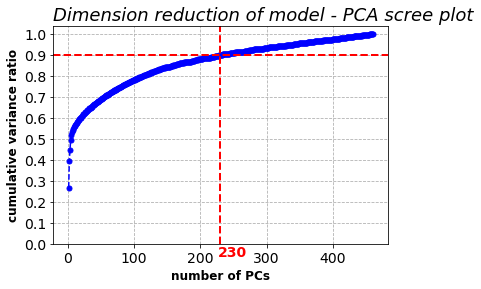

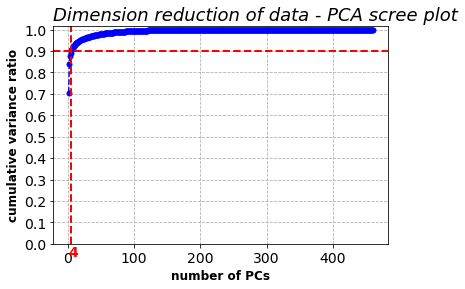

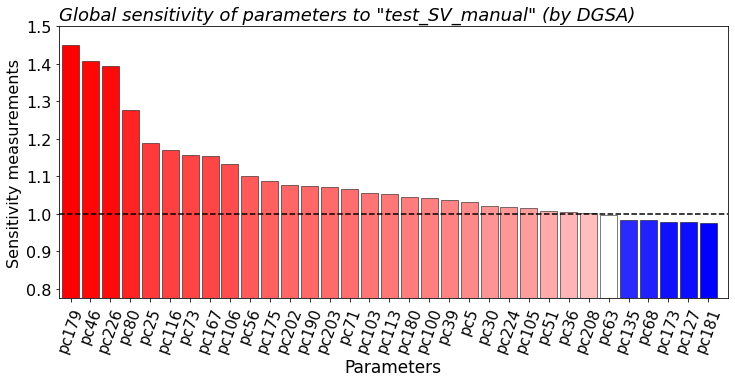

In [30]:


#FROM AUTOBEL

autobeldir = 'source_code/'
if autobeldir not in sys.path:
    sys.path.insert(0,autobeldir)


import numpy as np
from sklearn.decomposition import PCA

from source_code.scree_plot import scree_plot
from source_code.evd_fast import *
from source_code.RobustMD_flsification import RobustMD_flsification
from source_code.DGSA_light import DGSA_light
from source_code.gsa_pareto_plt import gsa_pareto_plt
from source_code.rgrplt_all_dh import rgrplt_all_dh 
from source_code.cca_and_ccaplt import cca_d_h
from source_code.cca_and_ccaplt import cca_plt
from source_code.gaussianregression_c_dd_star import *
from source_code.post_est_rtn_val import post_est_rtn_val
from source_code.post_est_rtn_val import post_est_clsplt
from source_code.plt_pos_pri_comp import plt_pos_pri_comp


from source_code.combine_mc_samples import *
from source_code.signed_distance_functions import *
from source_code.giip_cal import *

from source_code.gd_wellog_data import gd_wellog_data
from source_code.falsifications import fals_1Dplt, fals_2Dplt
from source_code.outlier_detection import outlier_2d
from source_code.plt_MC_models_smpls import m_ensampl_plt
from source_code.plt_MC_models_smpls import mc_samples_plot
from source_code.qc_reslts_plt import m_ensampl_plt


print("  ")
print("3. Dimension reduction of model and data")
'''m_pcnumsc: the number of model PCs to preserve in dimension reduction'''

model_name = 'test_SV_manual'

m_pcnums = []
m_pri = d_conc.copy()
m_pri[m_pri>100]=0.


m_pcnum =scree_plot(m_pri, 'model', 90, 'plot')
m_pcnums.append(m_pcnum)
m_mean_pri = m_pri.mean(axis=0)
m_eigvec_pri = evd_fast(m_pri, len(m_pri))
m_pcscr_pri=(m_pri-m_mean_pri).dot(m_eigvec_pri)

output_model = outputdir.joinpath('BEL',case,'model')
output_data = outputdir.joinpath('BEL',case,'data')

if not output_model.exists():
    output_model.mkdir(parents=True)
if not output_data.exists():
    output_data.mkdir(parents=True)




np.save(output_model.joinpath('{}_mean_pri.npy'.format(model_name)), m_mean_pri)
np.save(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)), m_eigvec_pri)
np.save(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)), m_pcscr_pri)

print("QC of the model eigen images")
# eigen_imgs_local(m_eigvec_pri, np.arange(10), matshape_conc)


#AEM
d_pri = np.log(d_AEM.copy())
d_pri[np.isnan(d_pri)]=0.

# d_pri = d_AEM.copy()
# d_obs = d_tds_obs.copy()
d_obs = d_AEM[408,:].reshape(1,-1)


d_pcnum =scree_plot(d_pri, 'data', 90, 'plot')
d_mean_pri = d_pri.mean(axis=0)
d_eigvec_pri = evd_fast(d_pri, len(d_pri))
d_pcscr_pri=(d_pri-d_mean_pri).dot(d_eigvec_pri)
d_pcscr_obs=(d_obs-d_mean_pri).dot(d_eigvec_pri)




np.save(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)), d_pcscr_pri)
np.save(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)), d_pcscr_obs)
np.save(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)), d_eigvec_pri)


##########################################################################
    ##           STEP 5. GSA               ##
##########################################################################
print("  ")
print("5. Global Sensitivity anlaysis-DGSA")
m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))[:, :m_pcnum]
d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))[:, :d_pcnum]

headers = []
for para in range(m_pcnum):
    headers.append('pc' + str(para + 1))
try:
    SA_measure = DGSA_light(m_pcscr_pri, d_pcscr_pri, headers)
except Exception as error:
    print(str(error))
gsa_pareto_plt(SA_measure, model_name)
np.save(output_data.joinpath('SA_measure_' + model_name + '.npy'), SA_measure)


np.save(output_data.joinpath('DGSA_synth_t{}_{}_conc{}_AEM{}.npy'.format(kper,model_name,job_id_conc,job_id_AEM)), SA_measure)


In [8]:
def eigen_imgs_local(eigen_vecs, eig_nums,matshape,slicenum=10):
    '''
    This is the function to plot the eigen_images
    arg:
        eigen_vecs: the ndarray of the eigen vectors
        eig_nums: 1d arrary defines which pc numbers to plot
        i_dim, j_dim: the i and j dimension of the grid model        
    '''
    plot_num = len(eig_nums)
    fig_row = int((plot_num+3)/4)
    fig=plt.figure(figsize=(15, fig_row*3))
    
    count = 1
    for i in eig_nums:
        plot=fig.add_subplot(fig_row, 4, count)
        count = count+1
        plt.imshow(eigen_vecs[:,i].reshape(matshape)[:,slicenum,:], cmap='jet')  
        plt.gca().set_aspect(7)
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)
        plt.title('model eigen_img (PC' + str(i) +')', fontsize = 14)
    plt.subplots_adjust(top=0.55, bottom=0.08, left=0.10, right=0.95, hspace=0.15,
                    wspace=0.35)
    
    #t = (" ")
    #plt.figure(figsize=(3, 0.1))
    #plt.text(0, 0, t, style='normal', ha='center', fontsize=16, weight = 'bold')
    #plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
    #plt.show()
    return

(array([], dtype=int64), array([], dtype=int64))

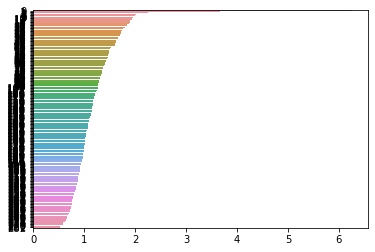

In [35]:
SA_measure_plot = SA_measure.sort_values(by=0, ascending=False)
sns.barplot(x=SA_measure_plot.values.flatten(),y=np.arange(len(SA_measure_plot)),orient='horizontal')

In [28]:
gsa_pareto_plt??

  0%|          | 0/3 [00:00<?, ?it/s]

  
6. Unceratinty reduction
  
6.1 QC model and data statistical relationships


100%|██████████| 3/3 [00:32<00:00, 10.74s/it]


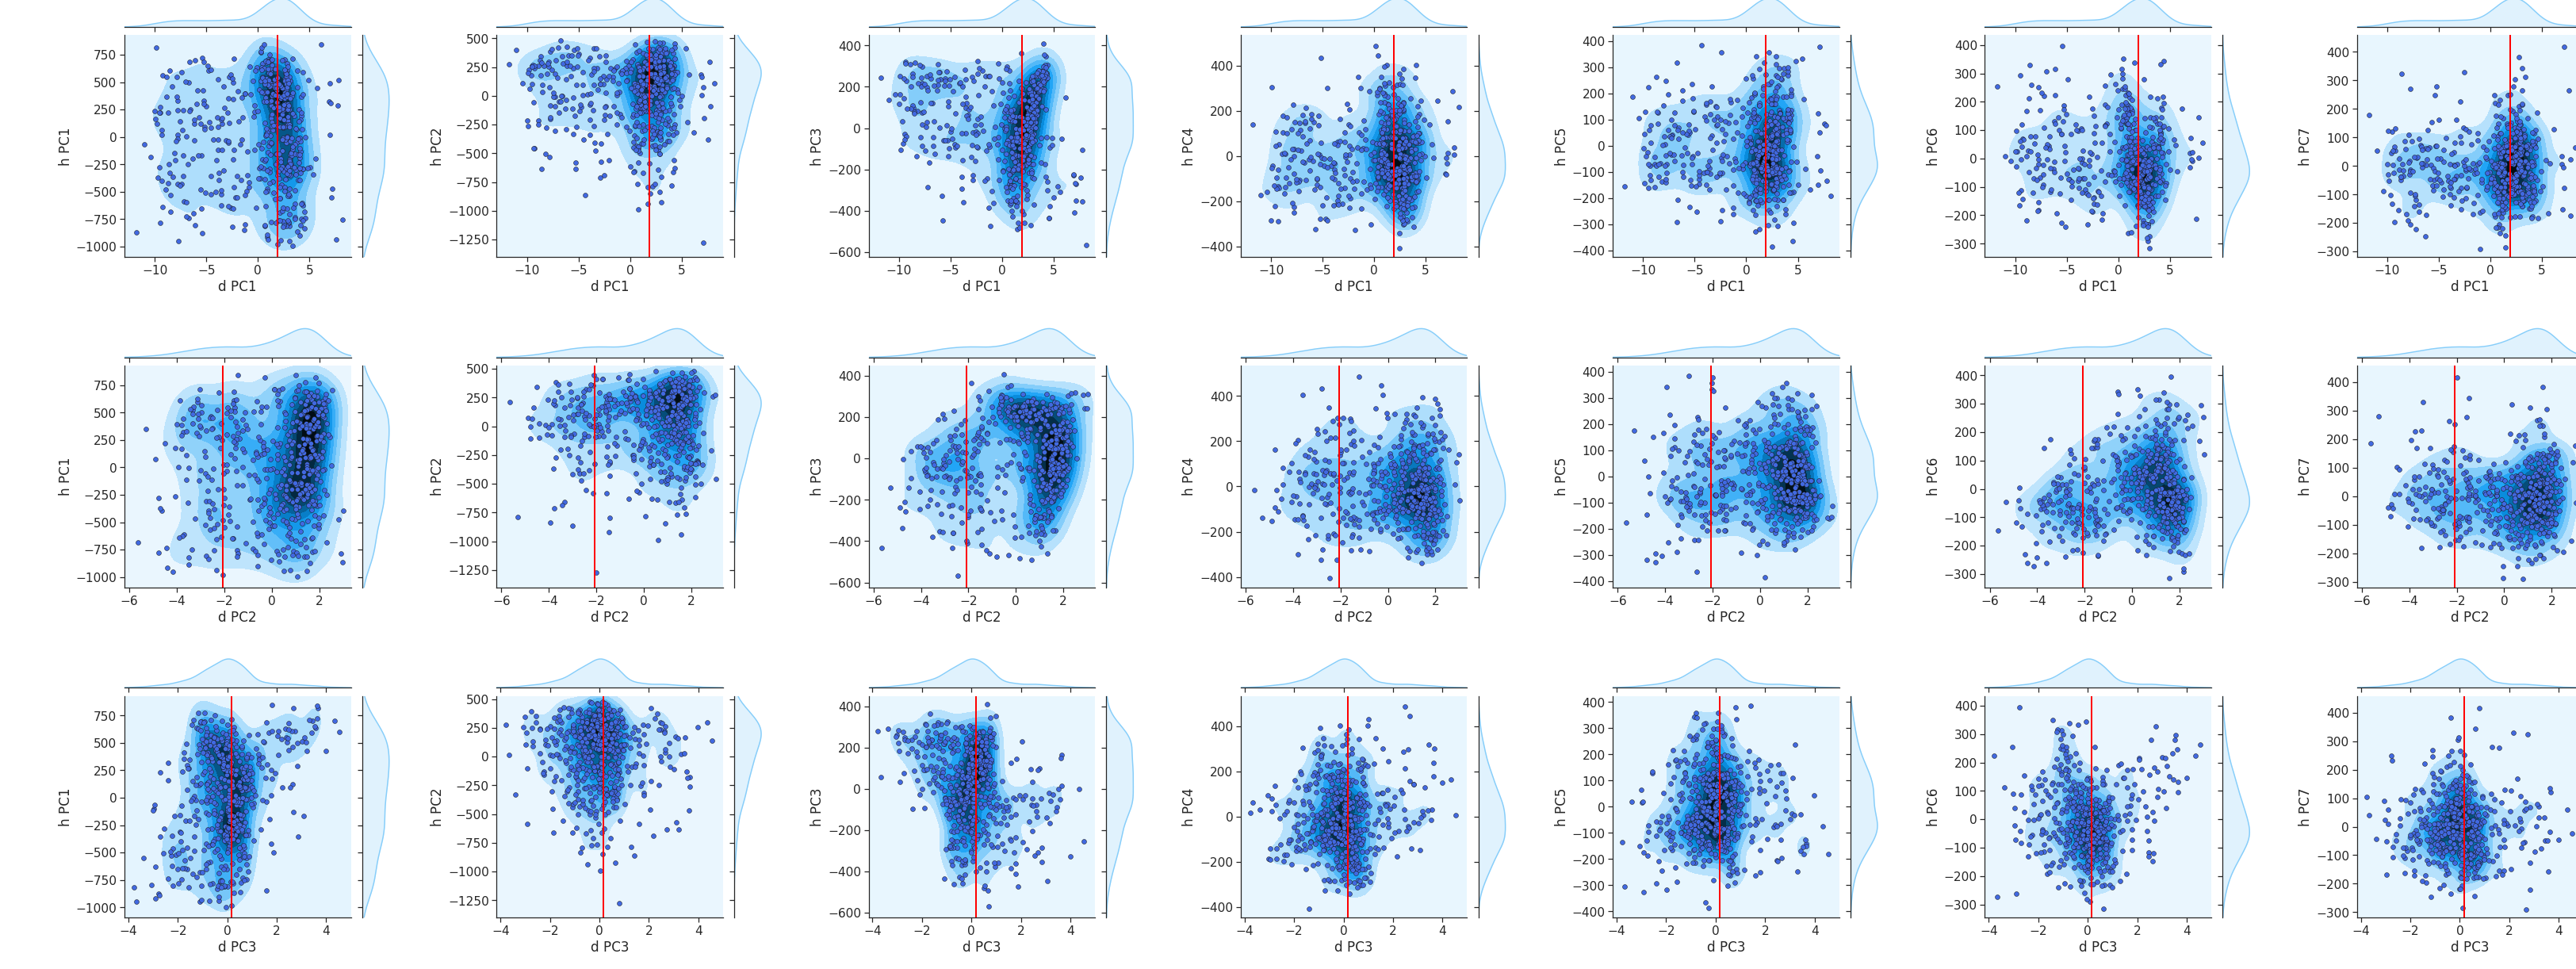

In [56]:
##########################################################################
    ##           STEP 6.  Uncertainty reduction              ##
##########################################################################
print("  ")
print("6. Unceratinty reduction")
print("  ")
##########################################################################
##          STEP 6.1     QC statistical relationships           ##
print("6.1 QC model and data statistical relationships")
SA_measure = np.load(output_data.joinpath('SA_measure_' + model_name + '.npy'))[:, 0]
sensitive_pcnum = np.argwhere(SA_measure > 1)[:len(d_pcscr[1]), 0]

m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))[:, :m_pcnum]
d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))[:, :d_pcnum]
d_pcscr_obs = np.load(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)))[:,:d_pcnum]

rgrplt_all_dh(d_pcscr_pri, m_pcscr_pri, d_pcscr_obs,
              [1, 2, 3], [1, 2, 3, 4, 5, 6, 7])

m_star = m_pcscr_pri[:, sensitive_pcnum]
d_star = d_pcscr_pri
dobs_star = d_pcscr_obs


In [78]:
d_c.shape

(494, 19)

In [83]:
m_c.shape

(494, 19)

In [81]:
cca_d_h??

In [82]:
m_star.shape

(494, 19)

  
6.2 Canonical Corrleation Analysis


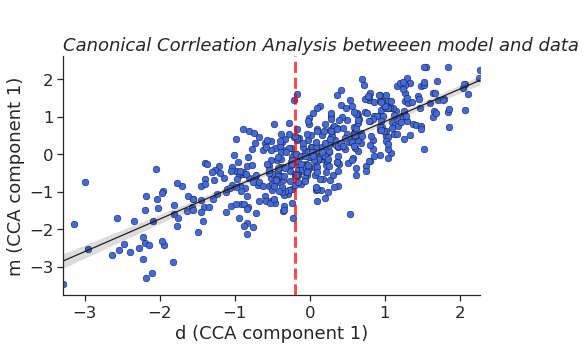

In [71]:
#######################################################################
##          STEP 6.2  CCA             ##
print("  ")
print("6.2 Canonical Corrleation Analysis")

d_c, m_c, ad, am = cca_d_h(d_star, m_star, len(m_star[0, :]))
dobs_c = np.matmul(dobs_star, ad)
d_c = np.matmul(d_star, ad)
m_c = np.matmul(m_star, am)
cca_plt(d_c, m_c, dobs_c, 1)


In [85]:
cal_c_dd_star_pca_cca??

  
6.3 Parametric Gaussian Regression & posterior sampling
  
6.4 Reconstruct posterior model


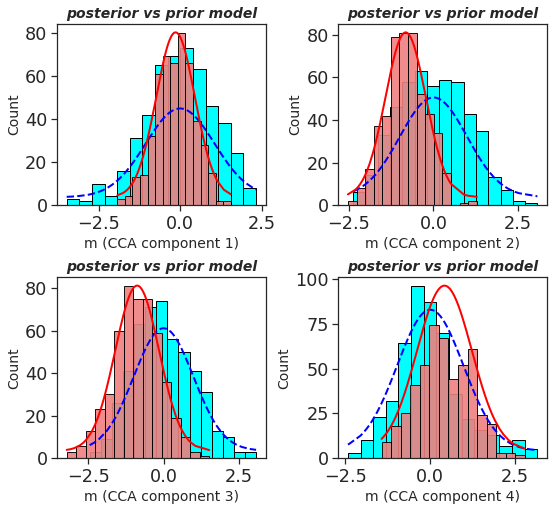

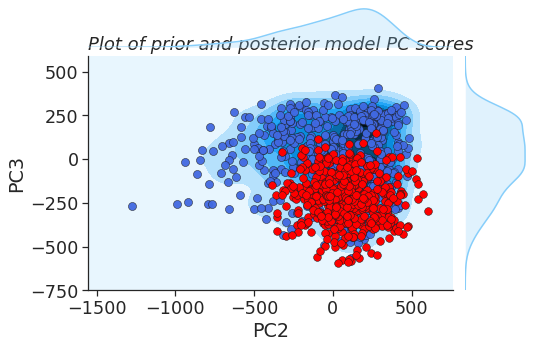

In [94]:

#######################################################################
##          STEP 6.3 Gaussian Regression                ##
print("  ")
print("6.3 Parametric Gaussian Regression & posterior sampling")

#######################################################################
##          STEP 6.4 Reconstruct posterior model                ##
err_levl = 0.00
dpca_eigenvec = np.load(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)))[:,:d_pcnum].T
cdd_star = cal_c_dd_star_pca_cca(dpca_eigenvec, ad, err_levl, d_obs)
post_est_clsplt([1, 2, 3, 4], m_c, d_c, dobs_c, cdd_star, 2, 2)

print("  ")
print("6.4 Reconstruct posterior model")
all_mc_post = []
for cca_comp in range(1, len(m_star[0, :]) + 1):
    all_mc_post.append(post_est_rtn_val(
        cca_comp, m_c, d_c, dobs_c, cdd_star, 0))
all_mc_post = np.asarray(all_mc_post).T
m_pcscr_post_SA = all_mc_post.dot(np.linalg.inv(am))
m_pcscr_post = np.load(output_model.joinpath(model_name + '_pcscr_pri.npy'))
m_pcscr_post[:, sensitive_pcnum] = m_pcscr_post_SA
plt_pos_pri_comp(
    sensitive_pcnum[0] + 1, sensitive_pcnum[1] + 1, m_pcscr_pri, m_pcscr_post)

m_eigvec = np.load(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)))

m_pri_mean = np.load(output_model.joinpath('{}_mean_pri.npy'.format(model_name)))

m_post = m_pcscr_post.dot(m_eigvec.T) + m_pri_mean
np.save(output_model.joinpath(model_name + '_model_post'), m_post)


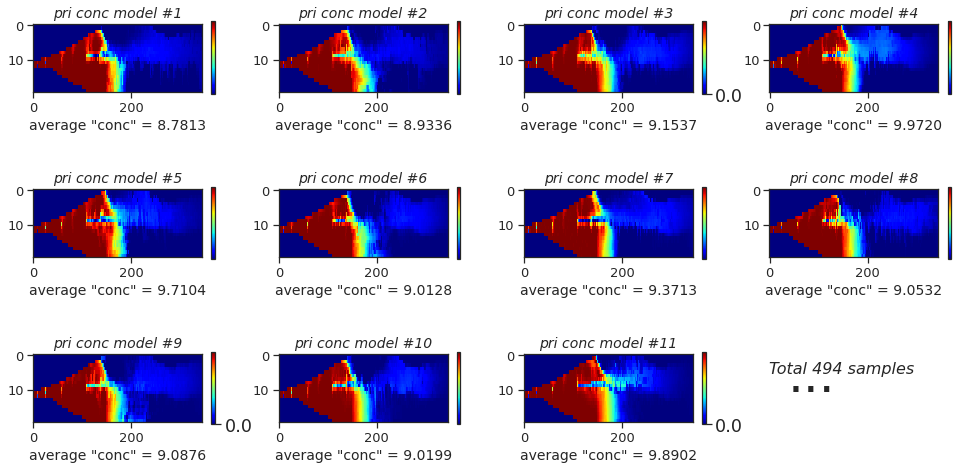

In [97]:
mc_samples_plot_2(m_post,'conc','pri',matshape_conc,10,aspect=7,cmap='jet',
                           vmin=0,vmax=35.,interpolation='nearest')


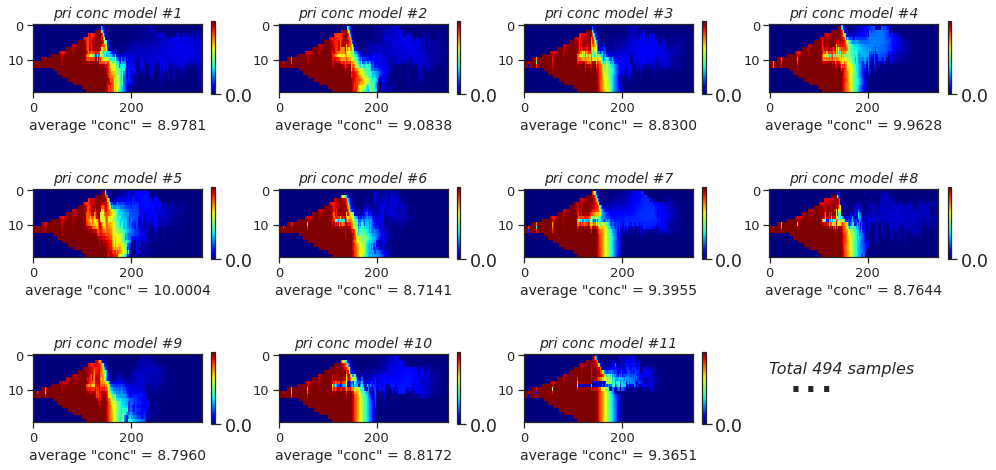

In [99]:
d_conc_plot = d_conc.copy()
d_conc_plot[d_conc==0]=0


mc_samples_plot_2(d_conc_plot,'conc','pri',matshape_conc,10,aspect=7,cmap='jet',
                           vmin=0,vmax=35.,interpolation='nearest')



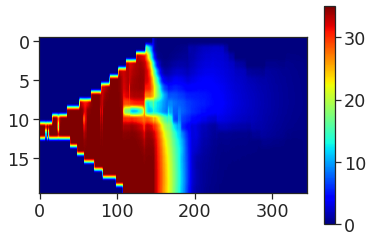

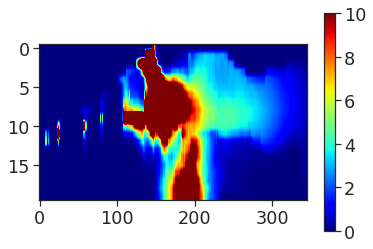

In [112]:
plt.imshow(d_conc_plot.mean(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=35)
plt.gca().set_aspect(10)
plt.colorbar()
plt.show()
plt.imshow(d_conc_plot.var(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=10)
plt.gca().set_aspect(10)
plt.colorbar()

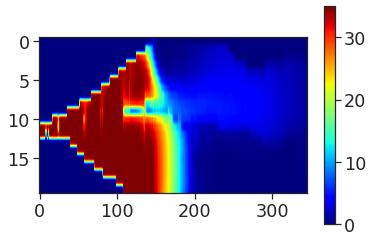

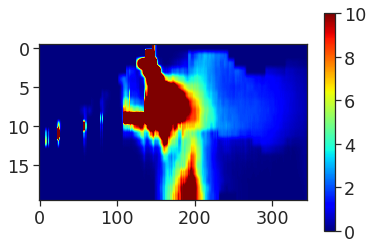

In [111]:
# m_post[m_post==0] = np.nan

plt.imshow(m_post.mean(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=35)
plt.gca().set_aspect(10)
plt.colorbar()
plt.show()
plt.imshow(m_post.var(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=10)
plt.gca().set_aspect(10)
plt.colorbar()

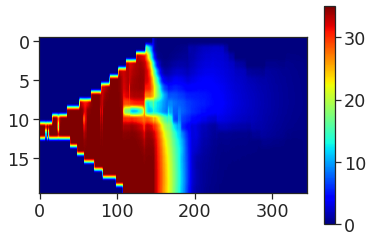

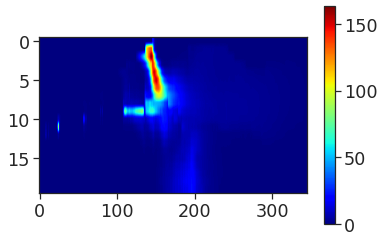

In [119]:
plt.imshow(d_conc_plot.mean(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=35)
plt.gca().set_aspect(10)
plt.colorbar()
plt.show()
plt.imshow(d_conc_plot.var(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet')
plt.gca().set_aspect(10)
plt.colorbar()

In [100]:
plt.subplots(figsize=(9,4.5))
sns.distplot(giip_a, bins=int(len(giip_a)/10), \
            kde_kws={'linewidth': 2,"color":"blue"}, \
            hist_kws={'color':'aqua',"edgecolor":'black','linewidth':0.6,'alpha':0.95})

sns.distplot(giip_b, bins=int(len(giip_b)/12.5), \
            kde_kws={'linewidth': 3,  "color":"red", }, \
            hist_kws={'color':'tomato',"edgecolor":'black','linewidth':0.6, 'alpha':0.7})
plt.ylabel('Density', fontsize = 20, fontname='calibri')
plt.xlabel('GIIP', fontsize = 20, fontname='calibri')
plt.title('Posterior and Prior predicton with "' + model_name+ '" model', fontsize=18, loc='right', style='italic')

(494, 131100)

In [96]:

def mc_samples_plot_2(model_ndarray, m_name, pri_post, matshape, layernum,aspect=1,**kwargs):
    '''
    Plot the 1st to 12th monte carlo model samples. 
    Args:
        model_ndarray: (str) the ndarray of monte carlo model samples, N_realizations x Grid_dims
        i_dim, j_dim, k_dim: x, y, z dimensions of one model realization. 
        layernum: which layer to show
        m_type: type of the model, 1 - continous; 2 - categorical
        
    Output:
        Pareto Plot for SA
    '''
    fig=plt.figure(figsize=(15,14))
    count = 1
    for realnum in range(12):
        if count  == 12:
            plot=fig.add_subplot(3, 4, count)
            plt.text(0.1, 0.48, '...', fontsize=50)
            plt.text(0.0, 0.6, 'Total ' + str(len(model_ndarray))+' samples', fontsize=16, style='italic')
            plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
            count = count + 1
        else:

            grid_data = model_ndarray[realnum].reshape(matshape)         
            plot=fig.add_subplot(3, 4, count)
            count = count+1

            prop_mean = format(np.mean(grid_data),'.4f')
            plot.set_xlabel('average "' + m_name + '" = ' + str(prop_mean), fontsize = 14)
            c_max = np.max(grid_data[layernum-1])*1.05
            c_min = np.min(grid_data[layernum-1])

            plt.imshow(grid_data[:,layernum,:],**kwargs)  
            plt.gca().set_aspect(aspect)
            plt.xticks(fontsize = 13)
            plt.yticks(fontsize = 13)
            plt.title(pri_post +' ' +m_name+ ' model #'+str(count-1), fontsize=14, style='italic')

#             plt.colorbar(fraction = 0.02)
            plt.colorbar(fraction = 0.02, ticks=np.around([c_min*1.1, c_max], decimals=1))
    plt.subplots_adjust(top=0.55, bottom=0.08, left=0.10, right=0.95, hspace=0.15,
                    wspace=0.35)
    return

In [121]:

#######################################################################
##          STEP 6.5 QC posterior results               ##

print("  ")
print("6.5. QC posterior results")
print("  ")
print("6.5.1 Plot posterior models")
m_pri = np.load(pri_m_samples_dir + model_names[i] + '.npy')
d_obs = np.c_[np.loadtxt(fname=dobs_file, skiprows=1)[:, :3], np.loadtxt(
    fname=dobs_file, skiprows=1)[:, i + 3:i + 4]]
# m_sampls_plt(m_post, samples_size, model_names[i], x_dim, y_dim, z_dim)
mc_samples_plot(m_post, model_names[i], model_types[
                i], 'Posterior', x_dim, y_dim, z_dim, 1)
m_ensampl_plt(m_post, m_pri,  model_names[
              i], 1, x_dim, y_dim, 1, d_obs)

print("  ")
print("6.5.2 Calculate posterior prediction")
GIIP_post = GIIP_cal(1, 0, m_post, grid_h_resolution, False)
np.save('output/prediction/GIIP_post', GIIP_post)
GIIP_pri = np.load('output/prediction/GIIP_pri.npy')
giip_compare(GIIP_pri, GIIP_post, model_names[i])



  
6.5. QC posterior results
  
6.5.1 Plot posterior models


NameError: name 'pri_m_samples_dir' is not defined

In [101]:
giip_compare??

In [38]:
d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))
m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))
d_pcscr_obs = np.load(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)))

In [26]:
m_pcscr_pri.shape

(494, 494)

In [23]:
np.save(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)), d_pcscr_obs)
np.save(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)), d_pca.components_)

np.load(output_model.joinpath('{}_mean_pri.npy'.format(model_name)))
np.load(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)))



['test']

In [66]:
from scipy.spatial.distance import pdist,squareform

In [67]:
# distmat = squareform(pdist(np.r_[d_AEM,d_obs.reshape(1,-1)],))
from scipy.spatial.distance import pdist,squareform
distmat = squareform(pdist(np.r_[d_pri,d_obs]))

In [153]:
maxind = np.argmax(distmat[-1,:-1])
its_AEM[maxind]

156

In [169]:
its_AEM[269]

280

In [168]:
np.where(distmat[-1,:-1]==np.sort(distmat[-1,:-1])[1])

(array([269]),)

In [68]:
minind = distmat[-1,:-1]
min_AEM = d_AEM[minind,:]

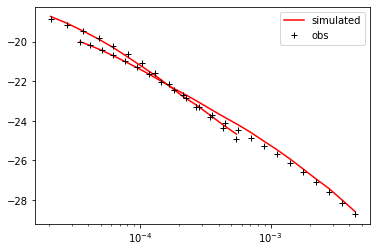

In [110]:
dHM,dLM = reshapeAEM(min_AEM)
dHMobs,dLMobs = reshapeAEM(d_obs_stash)

i_line=22
n_lines=1
plt.semilogx(times_HM_304,dHM[:,i_line:i_line+n_lines],'r',label='simulated')
plt.semilogx(times_LM_304,dLM[:,i_line:i_line+n_lines],'r')

plt.semilogx(times_HM_304,dHMobs[:,i_line:i_line+n_lines],'k+',label='obs')
plt.semilogx(times_LM_304,dLMobs[:,i_line:i_line+n_lines],'k+')
plt.legend()

In [109]:
diff_dbdt = np.abs(np.nanmin((dHM - dHMobs),axis=0))
diff_dbdt[np.isnan(diff_dbdt)]=100.
np.argmin(diff_dbdt)

22

In [112]:
its_AEM[minind]

406

In [115]:
case

'SV'

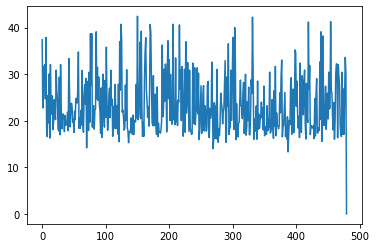

In [114]:
plt.plot(distmat[-1,:])


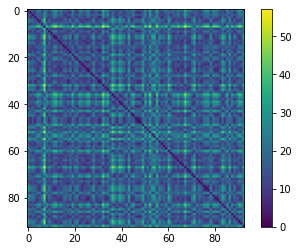

In [73]:
plt.imshow(distmat[minind:,minind:])
plt.colorbar()

(array([2.42000e+02, 7.25000e+02, 6.08800e+03, 1.49954e+05, 3.97700e+03,
        5.00000e+02, 5.50000e+01, 3.30000e+01, 1.40000e+01, 1.60000e+01]),
 array([-5.13202974e-09, -3.64171348e-09, -2.15139722e-09, -6.61080964e-10,
         8.29235295e-10,  2.31955155e-09,  3.80986781e-09,  5.30018407e-09,
         6.79050033e-09,  8.28081659e-09,  9.77113285e-09]),
 <a list of 10 Patch objects>)

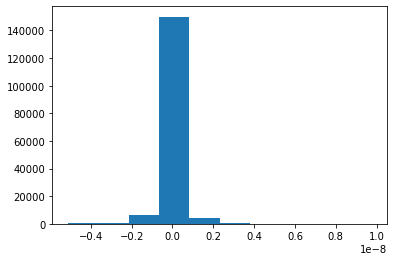

In [116]:
plt.hist((d_pri-d_obs).flatten())

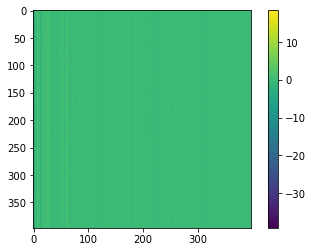

In [87]:
plt.imshow(d_pri-d_obs)
plt.colorbar()

##### Load observed data

##### Mahabonabonlis distance

In [ ]:
m_eigvec_pri.shape

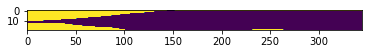

In [41]:
plt.imshow(d_conc[0].reshape(matshape_conc)[:,0,:])

### Plot

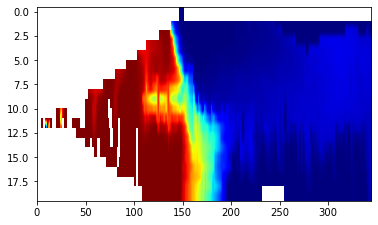

In [94]:
conc[conc>100]=np.nan

plt.imshow(conc[:,10,:],vmin=0,vmax=35.,cmap='jet')
plt.gca().set_aspect(10)

In [76]:
for f in ucn

TypeError: only integer scalar arrays can be converted to a scalar index

In [74]:
dd = {}

for 



233

In [59]:
data

In [19]:
ucnpaths = glob.glob(output_SV.joinpath('*_{}.UCN'.format(job_id)).as_posix())
f= ucnpaths[0]
f.split('_')

['/scratch/users/ianpg/SWIlarge/work/output/SV/conc75',
 '20200704',
 '1110',
 'totim14782',
 '3573022.UCN']

In [25]:
totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
